# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##  you can  download it with 4 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [1]:

import os
import pandas as pd
import numpy as np
import seaborn
import geopandas as  gpd
import zipfile #i am not giving it a name cause i intend to use it only once
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

path = os.getenv("PUIDATA") + '/'


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

This website id currently down. I uploaded the geojson file in the github repo as well

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [2]:
path = os.getenv("PUIDATA") + '/'
data = pd.DataFrame()
for year in range(1994,2015):
    file = 'zbp' + str(year)[2:4] + 'totals.zip'
    zf = zipfile.ZipFile(path + file)
    df = pd.read_csv(zf.open(file.replace('.zip','.txt')))
    if any(df.columns == 'est'):
        temp = df[[ 'est', 'zip']]
    elif any(df.columns == 'EST'):
        temp = df[[ 'EST', 'ZIP']]
        temp = temp.rename(columns={'EST': 'est', 'ZIP':'zip'})
    temp['year'] = year
    data = pd.concat([data, temp], axis = 0)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
data.zip.unique()

array([ 1001,  1002,  1003, ..., 94258, 97703, 98481])

In [4]:

geo = gpd.read_file(path + '/nyc-zip-code-tabulation-areas-polygons.geojson')
geo = geo[['PO_NAME','geometry','postalCode','borough']]

In [5]:
geo = geo.rename(columns={'postalCode': 'zip'})
geo.head()

,PO_NAME,geometry,zip,borough
0,Jackson Heights,POLYGON ((-73.86942457284175 40.74915687096787...,11372,Queens
1,Glen Oaks,POLYGON ((-73.71068374074007 40.75004039450917...,11004,Queens
2,New Hyde Park,POLYGON ((-73.70098278625547 40.73889569923034...,11040,Queens
3,Bellerose,POLYGON ((-73.72270447144122 40.75373371438336...,11426,Queens
4,Fresh Meadows,POLYGON ((-73.81088634744755 40.72717187575918...,11365,Queens


In [6]:
# Select only NYC zipcodes
nyc= data.loc[data['zip'].isin(np.int64(geo.zip))]
nyc.head()

,est,zip,year
2966,6999,10001,1994
2967,1784,10002,1994
2968,3256,10003,1994
2969,1115,10004,1994
2970,1076,10005,1994


In [7]:
nyc.reset_index(drop=True, inplace=True)
nyc = nyc.pivot(index="zip", columns="year", values="est")

nyc.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [8]:
nyc = nyc.apply(lambda x: (x - x.mean())/x.std(), axis=1)
nyc.shape

(244, 21)

In [9]:
nyc = nyc.dropna()
nyc.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [10]:
nyc.fillna(0, inplace=1)

## KMeans

In [11]:
cb = KMeans(n_clusters=5, random_state=324).fit(nyc)
cluster_labels = cb.fit_predict(nyc)
cluster_labels

array([3, 3, 0, 0, 3, 2, 1, 0, 1, 3, 3, 2, 3, 1, 2, 0, 2, 1, 2, 2, 3, 3, 3,
       0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 3, 3, 1, 0, 3, 1, 1, 2, 4,
       4, 2, 4, 2, 2, 3, 0, 2, 3, 4, 2, 2, 2, 3, 2, 2, 4, 4, 4, 4, 1, 2, 2,
       0, 4, 2, 1, 0, 2, 2, 0, 2, 2, 4, 2, 2, 1, 3, 1, 3, 2, 3, 2, 3, 0, 0,
       0, 3, 0, 0, 3, 0, 3, 4, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       1, 0, 3, 0, 0, 0, 4, 4, 0, 3, 0, 0, 0, 3, 4, 0, 3, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 1, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 3, 3, 3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 3], dtype=int32)

In [12]:
centers = cb.cluster_centers_
centers.shape

(5, 21)

(1994, 2014)

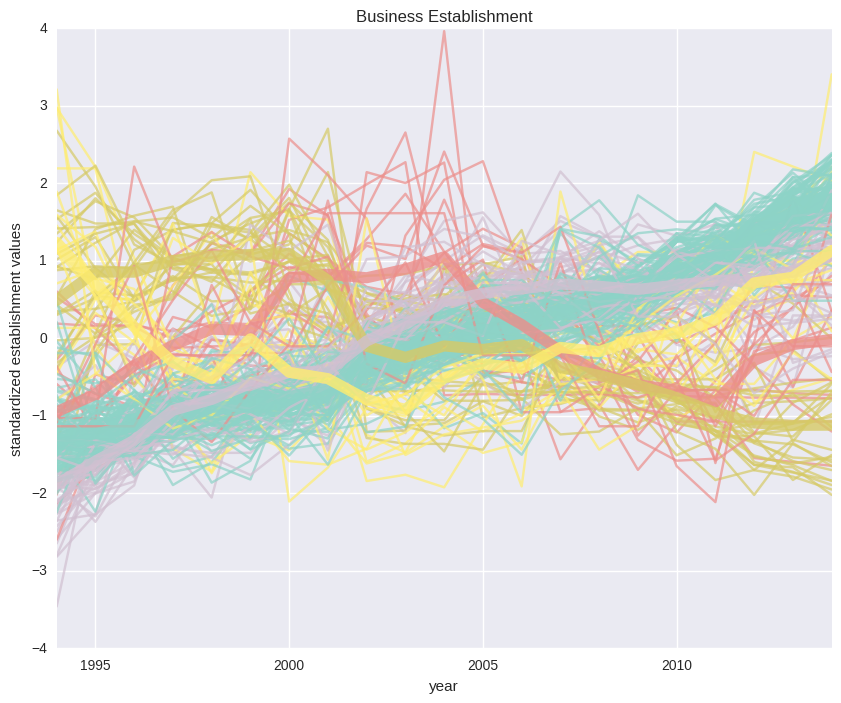

In [13]:
n = 5
cmap = plt.cm.Set3(np.linspace(0,1,n))
plt.figure(figsize=(10,8))
for i in range(len(nyc)):
    c = cluster_labels[i]
    plt.plot(range(1994,2015), nyc.iloc[i,:21], color=cmap[c][:3], alpha = 0.7)
for i in range(n):
    plt.plot(range(1994,2015), centers[i], color=cmap[i][:3], linewidth=8, alpha = 0.8)
plt.title('Business Establishment')
plt.ylabel('standardized establishment values')
plt.xlabel('year')
plt.xlim(1994,2014)
# This figure shows each year's business establishment.


## Hierarchy Clustering

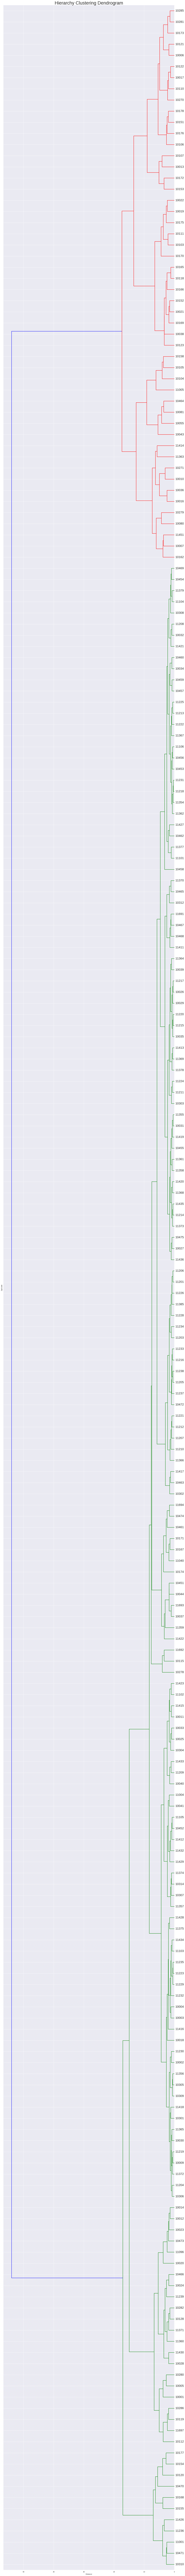

In [14]:
Z = linkage(nyc, 'ward')
plt.figure(figsize=(20, 300))
dendrogram(Z, orientation='left',labels = nyc.index.values, leaf_font_size=20)
plt.title('Hierarchy Clustering Dendrogram', fontsize = 30)
plt.xlabel('Distance')
plt.ylabel('ZipCode')
plt.show()

In [15]:
hc = fcluster(Z, 5, criterion='maxclust')

## overlap map plot

In [16]:
est = nyc.copy()
est['kmeans'] = cluster_labels


In [17]:
est['zip'] = est.index
est['zip'] = pd.to_numeric(est['zip'])
est['kmeans'] = pd.to_numeric(est['kmeans'])
est['hc'] = hc

In [18]:
geo['zip'] = pd.to_numeric(geo['zip'])
geo = geo.merge(est, on='zip')
geo.head(3)


,PO_NAME,geometry,zip,borough,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,kmeans,hc
0,Jackson Heights,POLYGON ((-73.86942457284175 40.74915687096787...,11372,Queens,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,...,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350,0,3
1,Glen Oaks,POLYGON ((-73.71068374074007 40.75004039450917...,11004,Queens,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,...,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923,3,3
2,New Hyde Park,POLYGON ((-73.70098278625547 40.73889569923034...,11040,Queens,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,-1.161866,...,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662,0,3


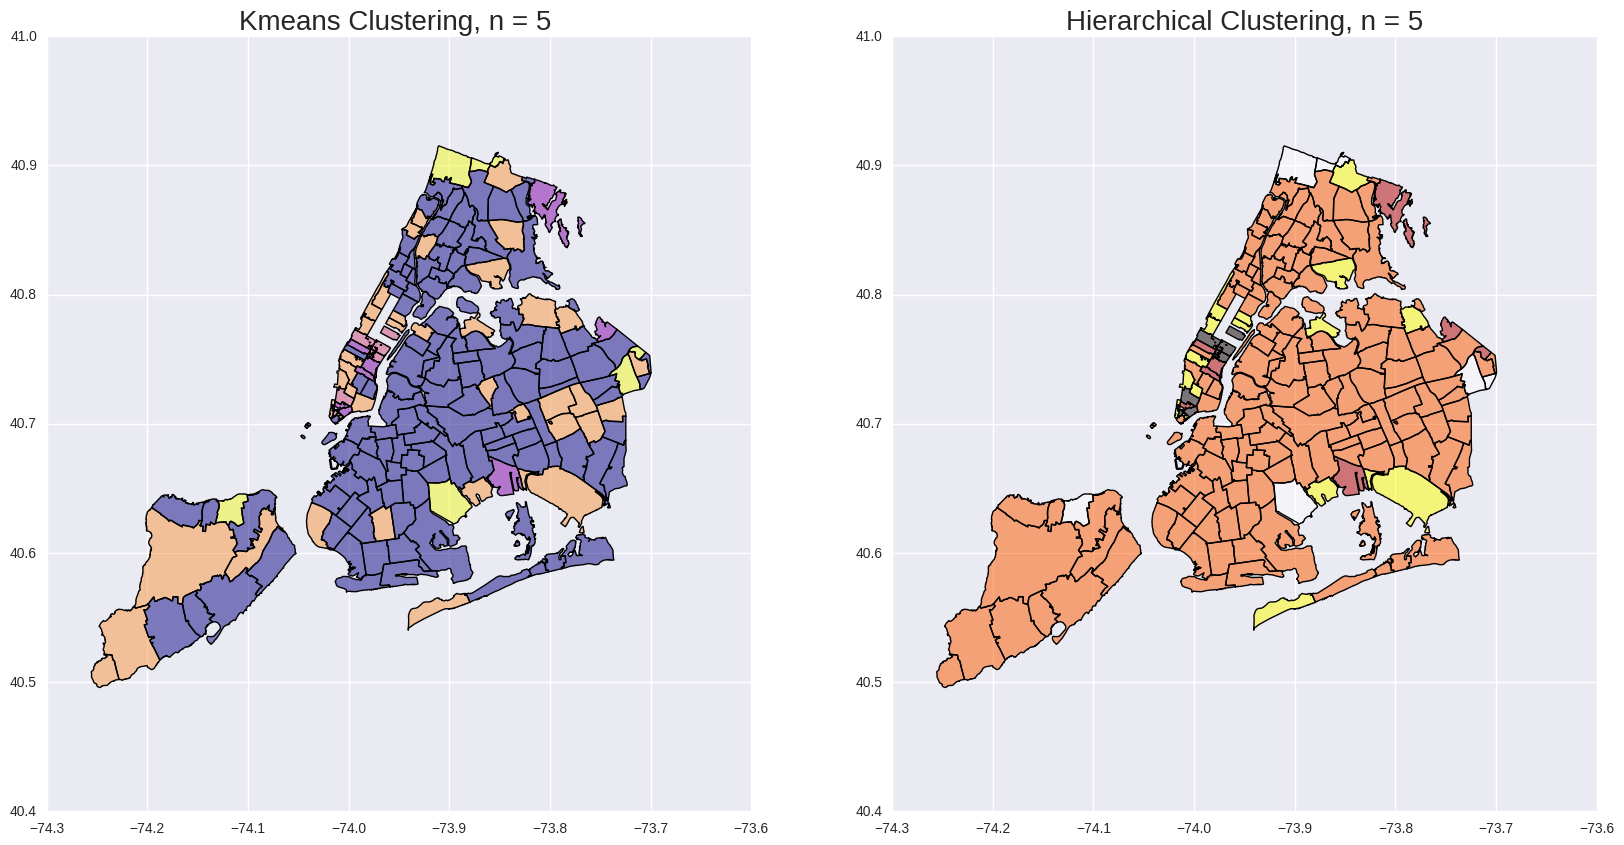

In [20]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
geo.plot(column = 'kmeans', cmap='plasma', ax=ax1)
ax1.set_title('Kmeans Clustering, n = 5 ', fontsize=20)
geo.plot(column = 'hc', cmap='hot_r', ax =ax2)
ax2.set_title('Hierarchical Clustering, n = 5', fontsize=20)


####  From these two clustering plots, we can see similar clustering results. However, there are some differences , such as the hierarchical clustering clusters the left lower part into almost all the yellow while the Kmeans clusters it into two colors. Perhaps there are some figures we can figure out in those areas.